In [1]:
import nltk
from IPython.display import display
from spacy import displacy
from nltk.stem import *
import random
import spacy
import re
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns

In [2]:
with open('uniq_taxon_words.txt', 'r') as file:
    uniq_taxon_names = file.readlines()
    
with open('comb_reg_words.txt', 'r') as file:
    comb_reg_words = file.readlines()
    
uniq_taxon_names = [x.strip() for x in uniq_taxon_names]
comb_reg_words = [x.strip() for x in comb_reg_words]

In [3]:
def calc_vowels_consonants_syllable(word):
    word = word.lower()
    SYLLABLE = 0
    VOWELS = 0
    CONSONANTS = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        SYLLABLE += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            SYLLABLE += 1
        if word[index] in vowels:    
            VOWELS += 1
        else:
            CONSONANTS += 1
    if word.endswith("e"):
        SYLLABLE -= 1
    if SYLLABLE == 0:
        SYLLABLE += 1
    return VOWELS, CONSONANTS, SYLLABLE

In [4]:
def last_char(word):
    '''
    Extract the last three characters of the word
    '''
    return word[-3:]
    
def first_char(word):
    '''
    Extract the first two characters of the word
    '''
    return word[:3]

def find_features(word):
    '''
    feature extraction and store into dictionary for training
    '''
    word = word.lower()
    word = re.sub(r'[^A-Za-z-]', '', word) # remove special chars
    n_vowels, n_consonants, n_syllables = calc_vowels_consonants_syllable(word)
    word_length = len(word) 
    
    try:
        ratio_vow_con = n_vowels/n_consonants   
    except ZeroDivisionError:
        ratio_vow_con = 1 
        
    try:
        ratio_vow_syl = n_vowels/n_syllables
    except ZeroDivisionError:
        ratio_vow_syl = 1
        
    return {'word_length':word_length, \
            'last_letters':last_char(word),\
            'first_letters':first_char(word),\
            'stem':stem_compute_v2(word),\
            'vowel_ratio':n_vowels/word_length,\
            'consonant_ratio':n_consonants/word_length,\
            'syllable_ratio':n_syllables/word_length, \
            'ratio_vow_con': ratio_vow_con, \
            'ratio_vow_syl': ratio_vow_syl
        }

stemmer = PorterStemmer()

def convert_chr(name):
    '''
    Convert the alphabet-ised word to a number
    '''
    chr_list = []
    for l in name:
        chr_list.append(ord(l.lower()))
    return sum(chr_list)

def stem_compute_v2(word):
    '''
    Output ratio of stem word to original word
    '''
    s_word = stemmer.stem(word)
    word_length = len(word)
    stem_length = len(s_word)
    ratio = stem_length / word_length
    return ratio

In [5]:
tup_taxon_words = [(f, find_features(f),True) for f in uniq_taxon_names]
tup_reg_words = [(f, find_features(f), False) for f in comb_reg_words[:len(uniq_taxon_names)]] #bc taxon names is shorter

In [6]:
feature_names = ['word_length', 'last_letters', 'first_letters', 'stem', 'vowel_ratio', 'consonant_ratio', 'syllable_ratio', 'ratio_vow_con','ratio_vow_syl']

In [7]:
def form_df(tup_words, feature_names):
    tup_word_list = []
    ft_names = feature_names.copy()
    for t in tup_words:
        tup_word_list.append((t[0], t[1][feature_names[0]], t[1][feature_names[1]], \
                                  t[1][feature_names[2]], t[1][feature_names[3]], \
                                  t[1][feature_names[4]], t[1][feature_names[5]], \
                                  t[1][feature_names[6]], t[1][feature_names[7]], \
                                  t[1][feature_names[8]], t[2]))

    ft_names.insert(0,'word')
    ft_names = ft_names + ['class']
    df = pd.DataFrame(tup_word_list, columns=ft_names)
    return df

In [8]:
df_reg_words = form_df(tup_reg_words, feature_names)

In [9]:
df_tax_words = form_df(tup_taxon_words, feature_names)

In [15]:
from sklearn.preprocessing import LabelEncoder
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import NMF 
import numpy as np

In [10]:
df_comb_words = df_reg_words.append(df_tax_words)
df_comb_words = df_comb_words.sample(frac=1).reset_index(drop=True)
df_comb_words['last_letters'] = df_comb_words['last_letters'].apply(lambda x: ''.join(format(ord(w), 'b') for w in x) )
df_comb_words['first_letters'] = df_comb_words['first_letters'].apply(lambda x: ''.join(format(ord(w), 'b') for w in x) )

In [17]:
#Create x and y variables.
def output_X_y(df,feature_names):
    X = df.drop(columns=['class'])
    X = X[feature_names]
    y = df['class']
    return X, y

In [14]:
X, y = output_X_y(df_comb_words, feature_names)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=4)

In [39]:
# Fit on training set only
def run_scale_pca(train_x, test_x, n_pca_cmpts):
    sc = StandardScaler()
    X_train = sc.fit_transform(train_x)
    X_test = sc.transform(test_x)
    pca = PCA(n_pca_cmpts)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return pca, X_train, X_test

In [19]:
pca, X_train,X_test = run_scale_pca(train_x, test_x, 8)

In [20]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.37193985 0.16452871 0.12817834 0.1149859  0.10487242 0.09368629]


In [21]:
labels = ['PC' + str(x) for x in range(1, X_train.shape[1]+1)]
pca_df = pd.DataFrame(X_train,columns=labels)

In [22]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.482233,1.668045,1.018071,-0.588415,0.068314,1.531414
1,-1.437774,-0.155559,-1.214982,-0.604368,-1.081090,0.323337
2,0.470220,-1.090549,-1.265459,0.925869,0.859639,-0.274013
3,5.394482,1.583652,-0.440905,-0.922316,-1.829906,-0.629142
4,-2.083135,-1.220733,-0.968717,0.852899,0.878304,0.163489


In [72]:
features.shape

(6, 496036)

In [23]:
features = X_train.T
cov_matrix = np.cov(features)
eigval,eigvec = np.linalg.eig(cov_matrix)

In [24]:
tot = sum(eigval) 
var_exp = [(i/tot)*100 for i in sorted(eigval, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 38.00928335,  54.83087546,  67.92164935,  79.67581901,
        90.40583827, 100.        ])

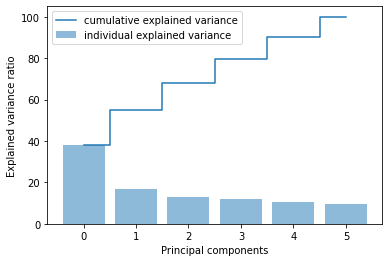

In [27]:
plt.figure(figsize=(6, 4))
plt.bar(range(eigval.shape[0]), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(eigval.shape[0]), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

Text(0.5, 0, 'PC3')

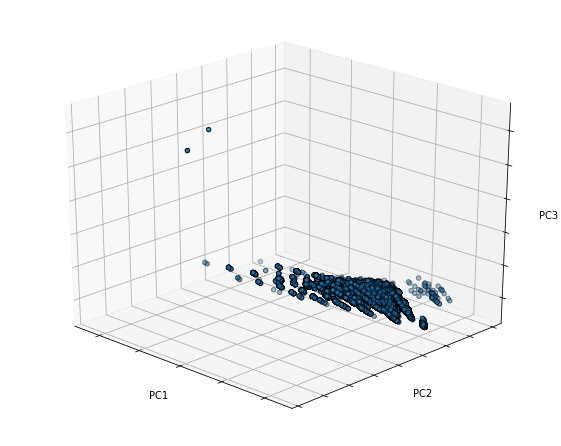

In [23]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=134)
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [24]:
def format_feats_into_df(word):
    df = pd.DataFrame(find_features(word).items()).transpose()
    df.columns = df.iloc[0].copy()
    df['last_letters'] = df['last_letters'].apply(lambda x: ''.join(format(ord(w), 'b') for w in x) )
    df['first_letters'] = df['first_letters'].apply(lambda x: ''.join(format(ord(w), 'b') for w in x) )
    df.drop([0], inplace=True)
    return df.iloc[0]

In [34]:
new_data = np.array(format_feats_into_df('MYCALOLIDES'))
new_data

array([11, '110010011001011110011', '110110111110011100011',
       0.8181818181818182, 0.45454545454545453, 0.45454545454545453,
       0.45454545454545453, 1.0, 1.0], dtype=object)

In [40]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, train_y)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [45]:
cm = confusion_matrix(test_y, y_pred)
print(cm)
print('Accuracy: ' + str(accuracy_score(test_y, y_pred)))

[[19100  8458]
 [ 7667 19891]]
Accuracy: 0.7074352275201393


In [48]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, train_y)

LogisticRegression()

In [55]:
from random import randint

In [62]:
logisticRegr.predict(X_test[randint(0, X_test.shape[0])].reshape(1,-1))

array([ True])

In [51]:
logisticRegr.predict(X_test[:10])

array([False,  True, False, False,  True,  True, False,  True, False,
        True])

In [66]:
y_pred = logisticRegr.predict(X_test)

In [63]:
X_test[0]

array([-2.21059641, -0.92636098, -0.47127922,  0.84057725,  0.60388819,
       -0.79367846])

In [65]:
logisticRegr.score(X_test, test_y)

0.7214783365991727

In [67]:
cm = confusion_matrix(test_y, y_pred)
print(cm)
print('Accuracy: ' + str(accuracy_score(test_y, y_pred)))

[[18904  8654]
 [ 6697 20861]]
Accuracy: 0.7214783365991727


In [73]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, train_y)

KNeighborsClassifier(n_neighbors=2)

In [75]:
y_pred = knn.predict(X_test)

In [76]:
cm = confusion_matrix(test_y, y_pred)
print(cm)
print('Accuracy: ' + str(accuracy_score(test_y, y_pred)))

[[24369  3189]
 [ 8641 18917]]
Accuracy: 0.7853617824225271


In [56]:
run_gsrch(knn_2, hyperparameters_knn, X_train,train_y)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed: 14.3min finished


Best params: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# GRID SEARCH FOR SVM SVC 
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
classifiers = [
    KNeighborsClassifier(),#1
    DecisionTreeClassifier(),#2
    RandomForestClassifier(),#3
    LogisticRegression(),#4
    SGDClassifier(),#max_iter = 500),#5
    MultinomialNB(),#6
    SVC(kernel = 'linear'),#7
    BernoulliNB(),#8
    LinearSVC(),#9
    ComplementNB()
    NuSVC()#10
]


In [25]:
X, y = output_X_y(df_comb_words, feature_names)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=4)

In [33]:
def scale_pca(train_x, train_y, possible_ncompts):
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA())])

    param_grid = dict(reduce_dims__n_components=possible_ncompts)
    pca_grid = GridSearchCV(pipe, param_grid=param_grid, cv=4, n_jobs=-1, verbose=2)
    pca_grid.fit(train_x, train_y)
    n_compts = grid.best_estimator_['reduce_dims'].n_components_
    print(f"optimal PCA components: {n_compts}")
    return n_compts, grid

In [21]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [22]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [24]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [25]:
LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [26]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [19]:
SGDClassifier().get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [42]:
''' RANDOMSIED HYPERPARAMTER TUNING RANDOMFOREST'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid_randfor = {'clf__n_estimators': n_estimators,
                       'clf__max_features': max_features,
                       'clf__max_depth': max_depth,
                       'clf__min_samples_split': min_samples_split,
                       'clf__min_samples_leaf': min_samples_leaf,
                       'clf__bootstrap': bootstrap}

In [30]:
print(random_grid_randfor)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [102]:
''' RANDOMISED HYPERPARAMETER TUNING KNN '''

random_grid_knn = dict(pca__n_components=list(range(2,12,2)),
                      clf__leaf_size=list(range(1,4)), 
                      clf__n_neighbors=list(range(2,6)),
                      clf__p=[1,2],
                      clf__weights=['uniform', 'distance'],
                      clf__algorithm=['auto', 'ball_tree','kd_tree','brute'])

In [59]:
''' RANDOMISED HYPERPARAMETER TUNING SVC '''

random_grid_svc = dict(pca__n_components=list(range(2,12,2)),
                      clf__gamma=np.logspace(-4,3,6), 
                      clf__C=np.logspace(-1,2,6),
                      clf__kernel=['rbf'])

In [71]:
''' RANDOMISED HYPERPARAMETER TUNING LINEAR SVC '''

random_grid_linsvc = dict(pca__n_components=list(range(2,12,2)),
                      clf__C=np.logspace(-1,2,6),
                      clf__dual=[True, False],
                      clf__loss=['hinge', 'squared_hinge'],
                      clf__penalty=['l1', 'l2'])

In [100]:
''' RANDOMISED HYPERPARAMETER TUNING SGD '''
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

random_grid_sgd = dict(pca__n_components=list(range(2,12,2)),
                       clf__average=[True, False],
                       clf__l1_ratio=stats.uniform(0, 1),
                       clf__alpha=loguniform(1e-5, 1e0),
                       clf__penalty=['l2', 'l1', 'elasticnet'],
                       clf__learning_rate=['constant', 'optimal', 'invscaling', 'adaptive'],
                       clf__loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                       clf__eta0=np.logspace(-5,1,5),
                       clf__max_iter=(1000, 2000))

In [123]:
''' RANDOMISED HYPERPARAMETER TUNING DECISIONTREE '''

random_grid_dectree = dict(pca__n_components=list(range(2,12,2)),
                            clf__criterion=['gini', 'entropy'],
                            clf__splitter=['best', 'random'],
                            clf__max_depth=list(range(2,32,4)),
                            clf__min_samples_split=np.linspace(0.1, 1.0, 6, endpoint=True),
                            clf__min_samples_leaf=np.linspace(0.1,0.5, 6, endpoint=True),
                            clf__max_features=['auto', 'sqrt', 'log2'])

In [132]:
''' RANDOMISED HYPERPARAMETER TUNING LOGSITIC REGRESSION '''

random_grid_logreg = dict(pca__n_components=list(range(2,12,2)),
                         clf__solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                         clf__penalty=['l2', 'l1', 'elasticnet', 'none'],
                         clf__C=[300, 200, 100, 10, 1.0, 0.1, 0.01])

In [155]:
''' RANDOMISED HYPERPARAMETER TUNING MULTINOMIAL'''

random_grid_mulinb = dict(nmf__n_components=list(range(2,ceil(train_x.shape[1]/2.)*2 + 1,2)),
                         nmf__init=[None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar'],
                         nmf__solver=['mu', 'cd'],
                         clf__alpha=np.linspace(1e-4, 1000, 10, endpoint=True),
                         clf__fit_prior=[False, True])

In [173]:
''' RANDOMISED HYPERPARAMETER TUNING BERNOULLI '''

random_grid_bernoulli = dict(pca__n_components=list(range(2,ceil(train_x.shape[1]/2.)*2 + 1,2)),
                            clf__alpha=np.linspace(1e-4, 1000, 30, endpoint=True))

In [181]:
''' RANDOMISED HYPERPARAMETER TUNING COMPLEMENTNB'''

random_grid_compnb = dict(nmf__n_components=list(range(2,ceil(train_x.shape[1]/2.)*2 + 1,2)),
                         nmf__init=[None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar'],
                         nmf__solver=['mu', 'cd'],
                         clf__alpha=np.linspace(1e-4, 1000, 25, endpoint=True),
                         clf__norm=[True, False])

In [232]:
''' RANDOMISED HYPERPARAMETER TUNING NUSVC '''

random_grid_nusvc = dict(pca__n_components=list(range(2,ceil(train_x.shape[1]/2.)*2 + 1,2)),
                         clf__kernel=['linear', 'rbf', 'sigmoid'],
                         clf__nu=np.linspace(0,1,6, endpoint=False),
                         clf__gamma=['scale','auto'],
                         clf__degree=list(range(2,6)))

In [62]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = sum(predictions != test_y)
    num_of_test = len(test_y)
    accuracy = 100 - (100*errors/num_of_test)
    print('Model Performance')
    print('Number of Errors: {} out of {}.'.format(errors, num_of_test))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [160]:
# USE RANDOMIZED PARAMETERS TO GET GENERAL IDEA OF WHAT TO TUNE 

def randsrch_clf(train_x, train_y, clf, rand_param_grid, matrix_factor=True):
    # Use the random grid to search for best hyperparameters (general region then use GridSearchCV to hone in)
    # First create the base model to tune
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    # Fit the random search model
    if matrix_factor:
        pipe = Pipeline([('scalar', StandardScaler()), ('pca', PCA()), ('clf', clf)])
    else:
        from sklearn.decomposition import NMF 
        pipe = Pipeline([('nmf', NMF()), ('clf', clf)])
    rand_grid = RandomizedSearchCV(pipe, param_distributions=rand_param_grid, n_iter = 100, cv=3, n_jobs=-1, verbose=1, random_state=4)
    rand_grid.fit(train_x, train_y)
    print(rand_grid.best_score_)
    #print(rand_grid.cv_results_)
    return rand_grid


In [46]:
rf_random = randsrch_clf(train_x[:20000], train_y[:20000], RandomForestClassifier(), random_grid_randfor) 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 60.9min finished


0.7712666666666667
{'mean_fit_time': array([ 16.9313635 ,  68.33099469,  57.05125356, 111.80499967,
        44.82492391,  40.75379872,  53.43379394,  33.04015199,
        55.71260571,  65.88363663,  12.91104674,  43.41446408,
        73.41439295,  58.91227229,  40.54699548,  88.46436731,
        31.30372079,  35.00881632,  91.41409262,  21.35723337,
        94.88671859,  92.39355159,  50.20449376,  81.93134538,
        91.61159269,  26.17068942,  77.44596203,  33.73282305,
        95.56755265,  39.57308547,  55.54721268,  41.05820632,
        42.49075039,  25.33747506,  57.34502236,  38.44412502,
        39.52345697,  28.49371123,  27.12373694,  34.02188134,
         5.12237271,  19.60870393,  25.4381694 ,  12.62627999,
        10.21541699,  35.663112  ,  69.95407263,  19.57511234,
        57.9475294 ,  30.70363832,  92.66149672,  99.79315599,
        47.33143814,  47.70667704,  71.12277619,  28.75539692,
        41.08281295,  61.4885265 ,  49.71155596,  45.84645208,
         7.1766897

In [103]:
knn_random = randsrch_clf(train_x[:20000], train_y[:20000], KNeighborsClassifier(), random_grid_knn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.7min finished


0.7496498862425615
{'mean_fit_time': array([0.19669469, 0.17522295, 0.16754548, 0.16514794, 0.13723199,
       0.23023542, 0.84682433, 0.75117628, 0.80245129, 0.3310523 ,
       0.93961469, 0.16410255, 0.15246677, 0.16529767, 0.12309305,
       0.67375088, 0.262628  , 0.15823762, 0.14870898, 0.14106035,
       0.11597164, 0.2112271 , 0.19078223, 0.18823067, 0.35137765,
       0.24922776, 0.17550071, 0.12147895, 0.30304893, 0.51692192,
       0.37579894, 0.23304494, 0.405032  , 0.46237016, 0.6813465 ,
       0.27105045, 0.3334678 , 0.29057495, 0.60431719, 0.18319607,
       0.24330592, 0.14311433, 0.1847496 , 0.47151375, 0.45909476,
       0.16782959, 0.20280234, 0.21092828, 0.13850371, 0.13077633,
       0.14677199, 0.11472265, 0.70315544, 0.51965904, 0.21407501,
       0.2331752 , 0.18774486, 0.31631859, 0.37215233, 0.26213026,
       0.33589363, 0.25832001, 0.17100199, 0.43724426, 0.45574045,
       0.33927838, 0.38320494, 0.26181372, 0.31139104, 0.249458  ,
       0.19244297, 0.1597

In [61]:
svc_random = randsrch_clf(train_x[:20000], train_y[:20000], SVC(), random_grid_svc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


0.7732998438586921
{'mean_fit_time': array([1.05654543e+01, 1.59697703e+01, 8.89913313e+00, 1.05309426e+01,
       9.60186434e+00, 9.75492001e-02, 1.98244906e+01, 9.22488983e+00,
       7.04025428e-02, 9.38992635e+00, 1.02353948e+01, 4.41587268e+01,
       9.84915773e+00, 9.71316234e+00, 9.20490495e+00, 2.11813304e+01,
       7.17307727e-02, 7.21108683e+00, 9.19412907e+00, 6.53420289e-02,
       1.45914447e+01, 9.27580595e+00, 2.76705209e+01, 1.32980509e+01,
       9.26031669e+00, 8.52581445e+00, 2.23325802e+01, 2.06304444e+01,
       8.55537661e+00, 1.85676486e+01, 1.02457234e+01, 1.27251666e+01,
       9.72041011e+00, 8.50378871e+00, 1.99442132e+01, 2.02727992e+01,
       6.62150383e-02, 8.98056340e+00, 6.82733059e-02, 1.04906940e+01,
       1.51954830e+01, 9.89759151e+00, 7.05861251e-02, 7.23366737e-02,
       1.25493443e+01, 7.10874317e+01, 8.23483682e+00, 9.66339954e+00,
       6.85942968e-02, 7.11198600e+00, 9.78332535e+00, 1.86699135e+01,
       8.59402474e+00, 1.20948492e+01, 8

In [72]:
linsvc_random = randsrch_clf(train_x[:20000], train_y[:20000], LinearSVC(), random_grid_linsvc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.4s finished


0.7278999236356815
{'mean_fit_time': array([0.06282091, 0.09250458, 0.07034485, 0.07792624, 0.0412329 ,
       0.03592237, 0.05403169, 0.03990499, 0.04335093, 0.06031307,
       0.06308794, 0.06544058, 0.05795836, 0.0518051 , 0.05679496,
       0.04441857, 0.05493887, 1.36619171, 0.05600675, 0.0606281 ,
       0.08288598, 0.05958446, 0.07609304, 0.06492996, 0.04987764,
       0.05774665, 0.06393528, 0.06328328, 0.08836182, 0.08021402,
       0.14050603, 0.061656  , 0.07531778, 0.74955257, 0.06600475,
       0.06640466, 0.41529806, 0.09437784, 0.08746195, 0.10776869,
       0.15012058, 0.06173968, 0.058441  , 0.05136045, 0.05596193,
       0.05981406, 0.05610204, 0.85705463, 0.05100552, 0.05866567,
       0.07759825, 0.05888279, 0.05052098, 0.07596509, 0.05811405,
       0.05471222, 0.061927  , 0.0876507 , 0.07470592, 0.14148593,
       0.05916794, 0.04735438, 0.08264168, 2.44608863, 0.08965262,
       0.08197943, 0.07755295, 0.08294598, 0.06848431, 0.08205835,
       0.0812668 , 0.0778

/Users/trinhsk/miniconda3/envs/nltk/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [101]:
sgd_random = randsrch_clf(train_x[:20000], train_y[:20000], SGDClassifier(), random_grid_sgd)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s


0.727150028637182
{'mean_fit_time': array([0.06499505, 0.06514732, 0.12218165, 0.06336864, 0.13555678,
       0.08183869, 0.05986285, 0.10663684, 0.26558359, 0.13711786,
       0.05477738, 0.07266164, 0.03945398, 0.06104517, 0.0393587 ,
       0.09577195, 0.0533243 , 0.18026233, 0.08432849, 0.10943325,
       0.08662375, 0.04748925, 0.08012239, 0.06780338, 0.07103562,
       0.04016463, 0.07710433, 0.06955202, 0.12229013, 0.10363698,
       0.11103543, 0.11331956, 0.23221763, 0.12536232, 0.22010263,
       0.0863177 , 0.09438761, 0.085917  , 0.04399904, 0.08607475,
       0.17746623, 0.0622793 , 0.17610312, 0.1929183 , 0.09162426,
       0.07799204, 2.75235939, 0.0469052 , 0.58642411, 0.14272563,
       0.09152738, 0.14919035, 0.09179362, 0.08284235, 0.08229597,
       0.0568471 , 0.08707706, 0.10264969, 0.08939322, 0.05634967,
       0.05197096, 0.09181531, 0.0552024 , 0.10825602, 0.11960856,
       0.10371908, 0.13201102, 0.06034899, 0.10846432, 0.09847116,
       0.05767274, 0.08734

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished


In [124]:
dectree_random = randsrch_clf(train_x[:20000], train_y[:20000], DecisionTreeClassifier(), random_grid_dectree)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s


0.6959006460118039


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.8s finished


In [135]:
logreg_random = randsrch_clf(train_x[:20000], train_y[:20000], LogisticRegression(), random_grid_logreg)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s


0.7226500061135557


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.7s finished
/Users/trinhsk/miniconda3/envs/nltk/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [161]:
multinb_random = randsrch_clf(train_x[:20000], train_y[:20000], MultinomialNB(), random_grid_mulinb, False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.2s


0.5307999601520074


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.1s finished


In [174]:
bernoulli_random = randsrch_clf(train_x[:20000], train_y[:20000], BernoulliNB(), random_grid_bernoulli)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    5.0s remaining:    0.3s


0.6682498458335409


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.2s finished


In [182]:
compnb_random = randsrch_clf(train_x[:20000], train_y[:20000], ComplementNB(), random_grid_compnb, False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s


0.5298500076496325


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished


In [238]:
nusvc_random = randsrch_clf(train_x[:20000], train_y[:20000], NuSVC(), random_grid_nusvc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished


0.7728498813583173


In [48]:
rf_random.best_params_

{'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 'auto', 'clf__max_depth': 10, 'clf__bootstrap': True}

In [104]:
knn_random.best_params_

{'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 5, 'clf__leaf_size': 2, 'clf__algorithm': 'ball_tree'}

In [183]:
compnb_random.best_params_

{'nmf__solver': 'cd',
 'nmf__n_components': 4,
 'nmf__init': None,
 'clf__norm': True,
 'clf__alpha': 958.3333375}

In [175]:
bernoulli_random.best_params_

{'pca__n_components': 6, 'clf__alpha': 724.1379586206897}

In [162]:
multinb_random.best_params_

{'nmf__solver': 'cd',
 'nmf__n_components': 4,
 'nmf__init': None,
 'clf__fit_prior': True,
 'clf__alpha': 444.4445}

In [136]:
logreg_random.best_params_

{'pca__n_components': 8,
 'clf__solver': 'newton-cg',
 'clf__penalty': 'none',
 'clf__C': 200}

In [125]:
dectree_random.best_params_

{'pca__n_components': 8,
 'clf__splitter': 'best',
 'clf__min_samples_split': 0.28,
 'clf__min_samples_leaf': 0.1,
 'clf__max_features': 'log2',
 'clf__max_depth': 26,
 'clf__criterion': 'entropy'}

In [102]:
sgd_random.best_params_

{'clf__alpha': 0.0002966302282942478,
 'clf__average': False,
 'clf__eta0': 0.00031622776601683794,
 'clf__l1_ratio': 0.4016990910260366,
 'clf__learning_rate': 'adaptive',
 'clf__loss': 'hinge',
 'clf__max_iter': 1000,
 'clf__penalty': 'l2',
 'pca__n_components': 8}

In [73]:
linsvc_random.best_params_

{'pca__n_components': 8,
 'clf__penalty': 'l2',
 'clf__loss': 'hinge',
 'clf__dual': True,
 'clf__C': 6.30957344480193}

In [239]:
nusvc_random.best_params_

{'pca__n_components': 6,
 'clf__nu': 0.5,
 'clf__kernel': 'rbf',
 'clf__gamma': 'auto',
 'clf__degree': 3}

In [64]:
svc_random.best_params_

{'pca__n_components': 6,
 'clf__kernel': 'rbf',
 'clf__gamma': 0.0630957344480193,
 'clf__C': 25.118864315095795}

In [74]:
evaluate(linsvc_random, test_x, test_y)

Model Performance
Number of Errors: 14757 out of 55116.
Accuracy = 73.23%.


73.22556063575006

In [63]:
evaluate(svc_random, test_x, test_y)

Model Performance
Number of Errors: 12384 out of 55116.
Accuracy = 77.53%.


77.5310254735467

In [73]:
evaluate(rf_random, test_x, test_y)

Model Performance
Number of Errors: 12537 out of 55116.
Accuracy = 77.25%.


77.25342913128674

In [105]:
evaluate(knn_random, test_x, test_y)

Model Performance
Number of Errors: 13149 out of 55116.
Accuracy = 76.14%.


76.14304376224689

In [237]:
# LOG REGRESSION
param_grid_logreg = dict(pca__n_components=list(range(7,10)),
                      clf__C=np.linspace(180, 220, 4),
                      clf__solver=['newton-cg'],
                      clf__penalty=['none']) 
                        
# KNN
param_grid_knn = dict(pca__n_components=list(range(7,10)),
                      clf__leaf_size=list(range(1,4)), 
                      clf__n_neighbors=list(range(4,7)),
                      clf__p=[1,2])
# SVC
param_grid_svc = dict(pca__n_components=list(range(6,9)),
                      clf__gamma=np.linspace(0.05,0.07,4),
                      clf__C=np.linspace(24,26,4),
                      clf__kernel=['rbf'])

# LINEAR SVC
param_grid_linsvc = dict(pca__n_components=list(range(7,10)),
                      clf__C=np.linspace(4,7,4),
                      clf__penalty=['l2'],
                      clf__loss=['hinge'],
                      clf__dual=[True])
        
# RANDOM FOREST
param_grid_randfor = dict(pca__n_components=list(range(7,10)),
                          clf__max_depth=list(range(8,11)),
                          clf__n_estimators=list(range(200,600,100)),
                          clf__min_samples_split=[4,5,6],
                          clf__min_samples_leaf=[3,4,5],
                          clf__max_features=["auto"],
                          clf__bootstrap=[True])

# STOCHASIC GRADIENT DESCENT
param_grid_sgd =  dict(pca__n_components=list(range(7,10)),
                          clf__alpha=np.linspace(0.0002,0.0004,4),
                          clf__penalty=['l2'],
                          clf__eta0=np.linspace(0.0002, 0.0004,4),
                          clf__average=[False],
                          clf__max_iter=np.linspace(900,1300,4),
                          clf__l1_ratio=np.linspace(0.3, 0.5, 4),
                          clf__learning_rate=['adaptive'],
                          clf__loss=['hinge'])

# DECISION TREE
param_grid_dectree = dict(pca__n_components=list(range(7,9)),
                            clf__criterion=['entropy'],
                            clf__splitter=['best'],
                            clf__max_depth=list(range(25,27)),
                            clf__min_samples_split=np.linspace(0.1, 0.3, 3),
                            clf__min_samples_leaf=np.linspace(0.01, 0.1, 3),
                            clf__max_features=['log2'])

# MULTINOMIAL NB
param_grid_multinb = dict(nmf__solver=['cd'],
                         nmf__n_components=[3,4,5],
                         nmf__init=[None],
                         clf__fit_prior=[True],
                         clf__alpha=np.linspace(350, 550, 4))

# BERNOULLI NB
param_grid_bernoulli = dict(pca__n_components=list(range(5,8)),
                            clf__alpha=np.linspace(650, 800, 4))

# COMPLEMENT NB
param_grid_compnb = dict(nmf__solver=['cd'],
                         nmf__n_components=list(range(3,6)),
                         nmf__init=[None],
                         clf__norm=[True],
                         clf__alpha=np.linspace(850, 1000, 4))

# NU SVC
param_grid_nusvc = dict(pca__n_components=list(range(7,10)),
                         clf__nu=np.linspace(0.4,0.6,4),
                         clf__kernel=['rbf'],
                         clf__gamma=['scale'],
                         clf__degree=[3])

In [92]:
randfo_fit = gsrch_clf(train_x[:16000], train_y[:16000], RandomForestClassifier() , param_grid_randfor)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 13.4min finished


0.7714996271443942
{'mean_fit_time': array([0.83687186, 1.18377074, 1.18104696, 1.49200757, 2.21210702,
       2.24630197, 2.18333983, 3.27147063, 3.37835757, 0.80466803,
       1.20053673, 1.2385145 , 1.61021813, 2.28752923, 2.31398996,
       2.25810568, 3.25519395, 3.30826473, 0.78392037, 1.16465235,
       1.18460655, 1.48478929, 2.16860151, 2.21225055, 2.18697309,
       3.16849542, 3.27733898, 0.79600207, 1.1269083 , 1.14602407,
       1.49914757, 2.17934434, 2.2375412 , 2.23184435, 3.15703861,
       3.29770438, 0.7907292 , 1.15917301, 1.16451955, 1.5049746 ,
       2.19823639, 2.2118996 , 2.20377962, 3.19665106, 3.29940629,
       0.80521973, 1.13658063, 1.17390235, 1.47908902, 2.18041197,
       2.17766476, 2.21849028, 3.31534163, 3.25307401, 0.77821088,
       1.13554629, 1.15916006, 1.46819933, 2.21661894, 2.20465342,
       2.16128524, 3.17691604, 3.34564606, 0.82703694, 1.1496168 ,
       1.15981634, 1.48225371, 2.17963028, 2.20340792, 2.17284568,
       3.72775952, 4.4895

In [250]:
p.__module__

'sklearn.decomposition._pca'

In [247]:
p = PCA()
dir(p)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_fit',
 '_fit_full',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'copy',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'n_components',
 'random_state',
 'score',
 'score_samples',
 'set_params',
 'svd_solver',
 'tol',
 'transform',
 'whiten']

In [270]:
def gsrch_clf(clf, param_grid, X_train, y_train, matrix_factor=True):
    if matrix_factor:
        sc = StandardScaler()
        pca = PCA()
        pipe = Pipeline(steps=[('scaler',sc),\
                           ('pca', pca),\
                           ('clf', clf)])
    else:
        nmf = NMF()
        pipe = Pipeline(steps=[('nmf',nmf),\
                           ('clf', clf)])

    search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1, cv=3, scoring='accuracy')
    search.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    if matrix_factor:
        # Plot the PCA spectrum after scaling
        X_train_sc = sc.fit_transform(X_train)
        pca.fit(X_train_sc)

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12,12))
        ax0.plot(np.arange(1, pca.n_components_ + 1),
                 pca.explained_variance_ratio_, '+', linewidth=2) # marker as '+'
        ax0.set_ylabel('PCA explained variance ratio')

        n_pca_compts = search.best_estimator_.named_steps['pca'].n_components
        ax0.axvline(n_pca_compts,
                    linestyle=':', label=f'n_components chosen - {n_pca_compts}')
        ax0.legend(prop=dict(size=12))

        # For each number of components, find the best classifier results
        results = pd.DataFrame(search.cv_results_)
        components_col = 'param_pca__n_components'
        best_clfs = results.groupby(components_col).apply(
            lambda g: g.nlargest(1, 'mean_test_score')) # list largest row for mean_test_score

        best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
                       legend=False, ax=ax1)
        ax1.set_ylabel('Classification accuracy (val)')
        ax1.set_xlabel('n_components')
        plt.xlim(-1, pca.n_components_ + 2)
    
    print()
     
    y_pred = search.predict(test_x)
    cm = confusion_matrix(test_y, y_pred)
    print(cm)
    print()
    print('Accuracy: ' + str(accuracy_score(test_y, y_pred)))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  8.8min finished


Best parameter (CV score=0.771):
{'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'clf__n_estimators': 100, 'pca__n_components': 6}

[[19126  8425]
 [ 3803 23762]]

Accuracy: 0.7781406488134117


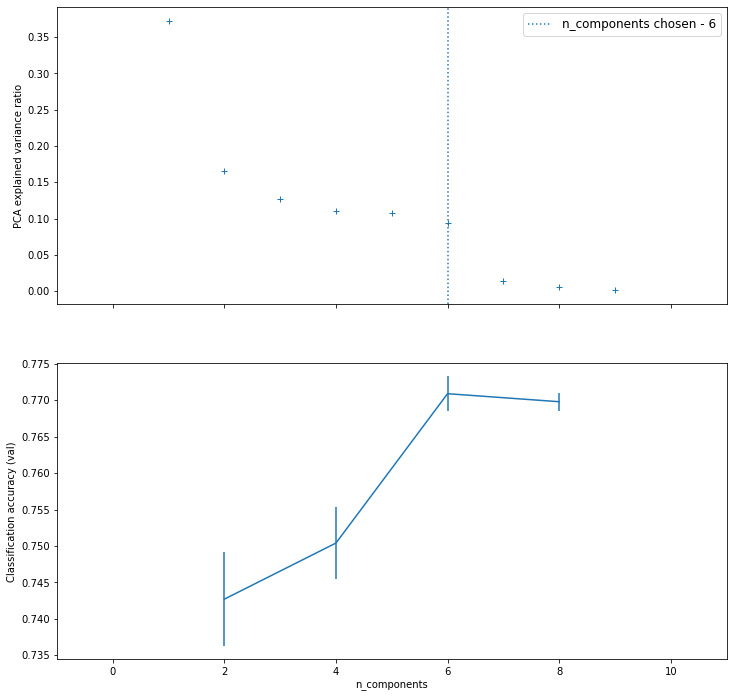

In [29]:
randfor_gsrch = gsrch_clf(RandomForestClassifier(), param_grid_randfor, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   15.2s finished


Best parameter (CV score=0.749):
{'clf__leaf_size': 1, 'clf__n_neighbors': 5, 'clf__p': 2, 'pca__n_components': 8}

[[20089  7462]
 [ 5601 21964]]

Accuracy: 0.7629907830756949


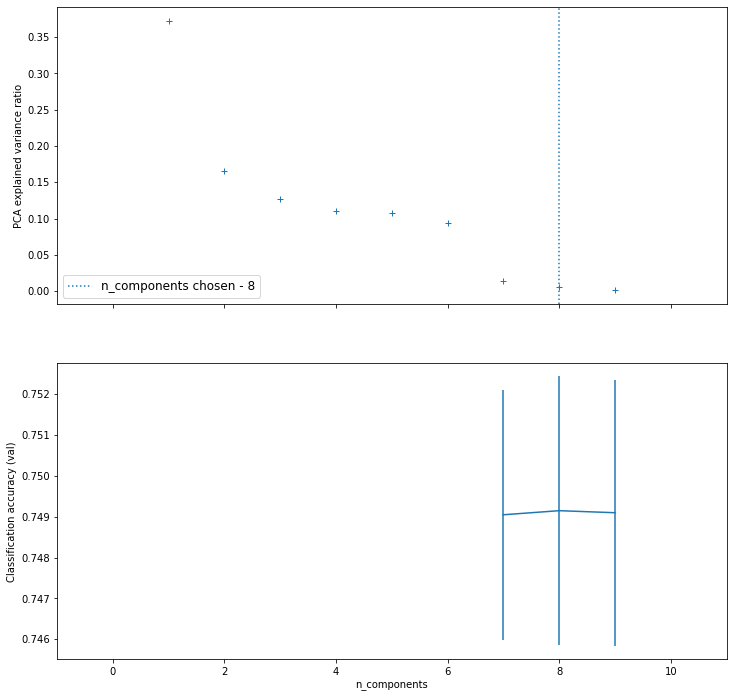

In [243]:
knn_gsrch = gsrch_clf(KNeighborsClassifier(), param_grid_knn, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:    9.7s finished


Best parameter (CV score=0.724):
{'clf__criterion': 'entropy', 'clf__max_depth': 25, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 0.1, 'clf__splitter': 'best', 'pca__n_components': 8}

[[15169 12382]
 [ 4008 23557]]

Accuracy: 0.7026271862979897


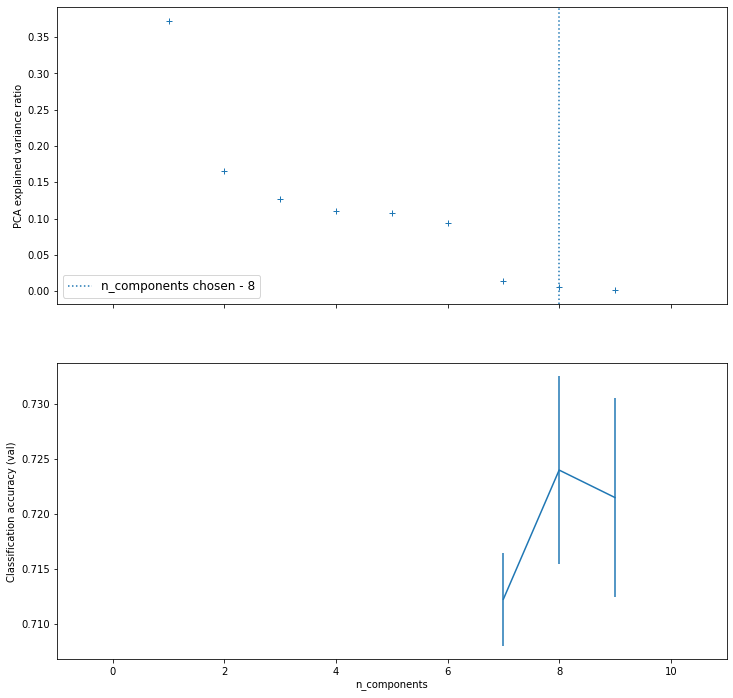

In [244]:
dectree_gsrch = gsrch_clf(DecisionTreeClassifier(), param_grid_dectree, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.0s finished
/Users/trinhsk/miniconda3/envs/nltk/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best parameter (CV score=0.731):
{'clf__C': 180.0, 'clf__penalty': 'none', 'clf__solver': 'newton-cg', 'pca__n_components': 9}

[[19239  8312]
 [ 6280 21285]]

Accuracy: 0.7352492924014805


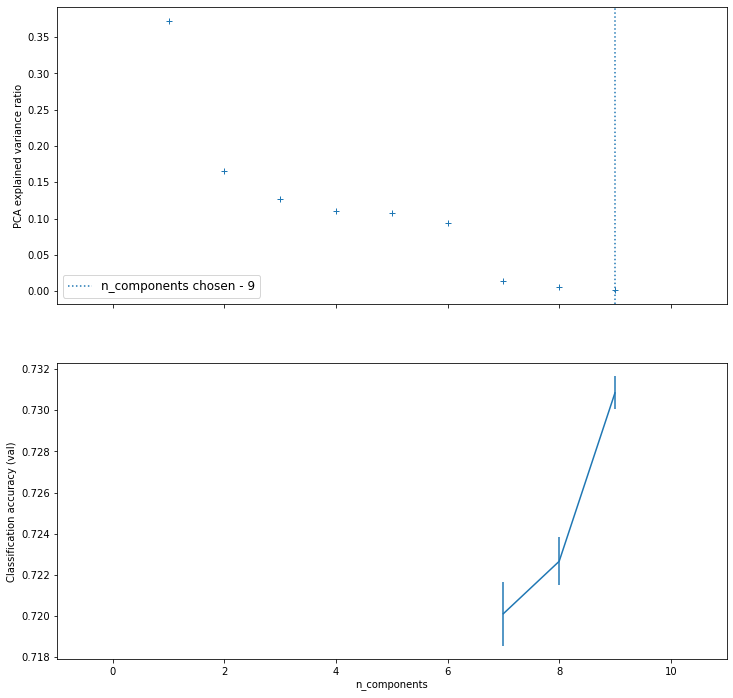

In [245]:
logreg_gsrch = gsrch_clf(LogisticRegression(), param_grid_logreg, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.5min finished


Best parameter (CV score=0.774):
{'clf__C': 24.0, 'clf__gamma': 0.05, 'clf__kernel': 'rbf', 'pca__n_components': 7}

[[18780  8771]
 [ 3675 23890]]

Accuracy: 0.7741853545250018


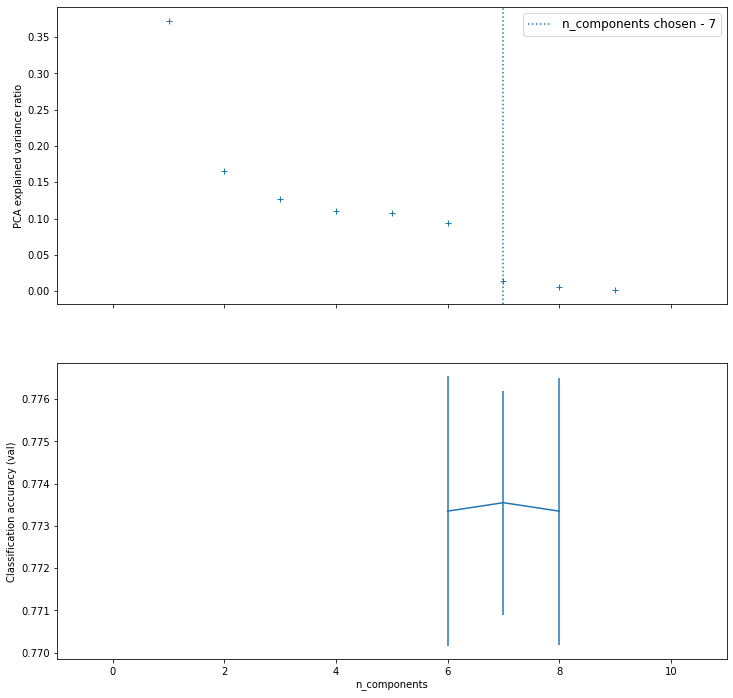

In [246]:
svc_gsrch = gsrch_clf(SVC(), param_grid_svc, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    4.5s finished
/Users/trinhsk/miniconda3/envs/nltk/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best parameter (CV score=0.736):
{'clf__C': 4.0, 'clf__dual': True, 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'pca__n_components': 9}

[[18521  9030]
 [ 5450 22115]]

Accuracy: 0.7372813702010306


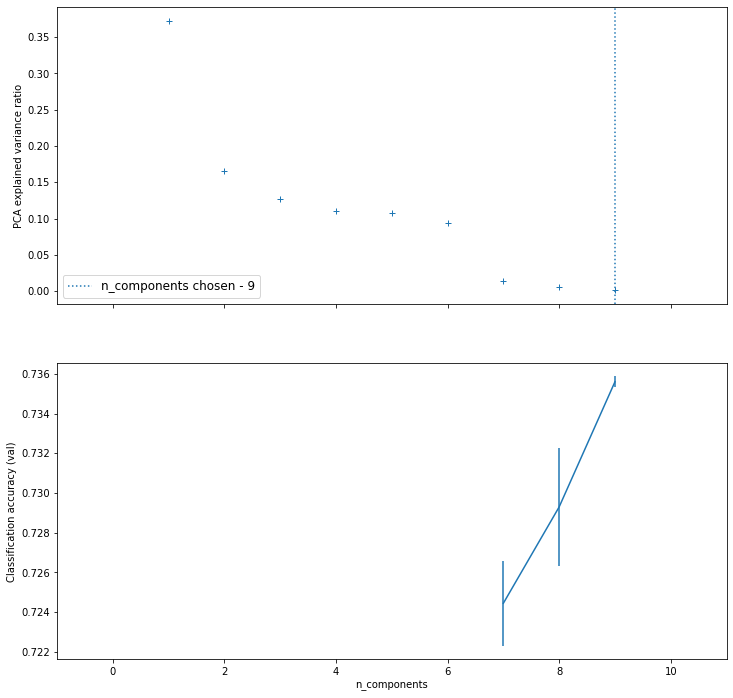

In [271]:
linsvc_gsrch = gsrch_clf(LinearSVC(), param_grid_linsvc, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.9min finished


Best parameter (CV score=0.773):
{'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__nu': 0.4666666666666667, 'pca__n_components': 7}

[[19119  8432]
 [ 3841 23724]]

Accuracy: 0.7773241889832354


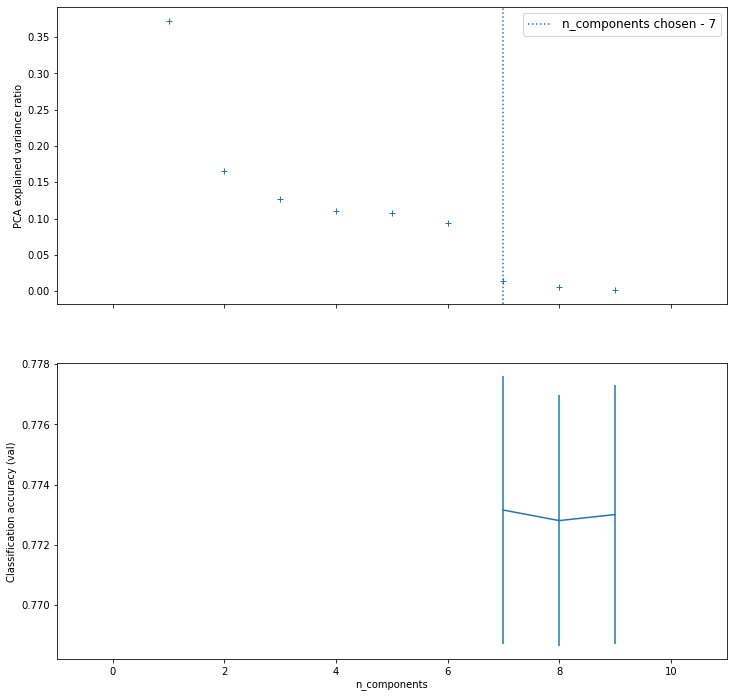

In [277]:
nusvc_gsrch = gsrch_clf(NuSVC(), param_grid_nusvc, train_x[:20000], train_y[:20000])

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:   57.0s finished


Best parameter (CV score=0.731):
{'clf__alpha': 0.0003333333333333334, 'clf__average': False, 'clf__eta0': 0.0004, 'clf__l1_ratio': 0.5, 'clf__learning_rate': 'adaptive', 'clf__loss': 'hinge', 'clf__max_iter': 1033.3333333333333, 'clf__penalty': 'l2', 'pca__n_components': 9}

[[18424  9127]
 [ 5520 22045]]

Accuracy: 0.7342513970534872


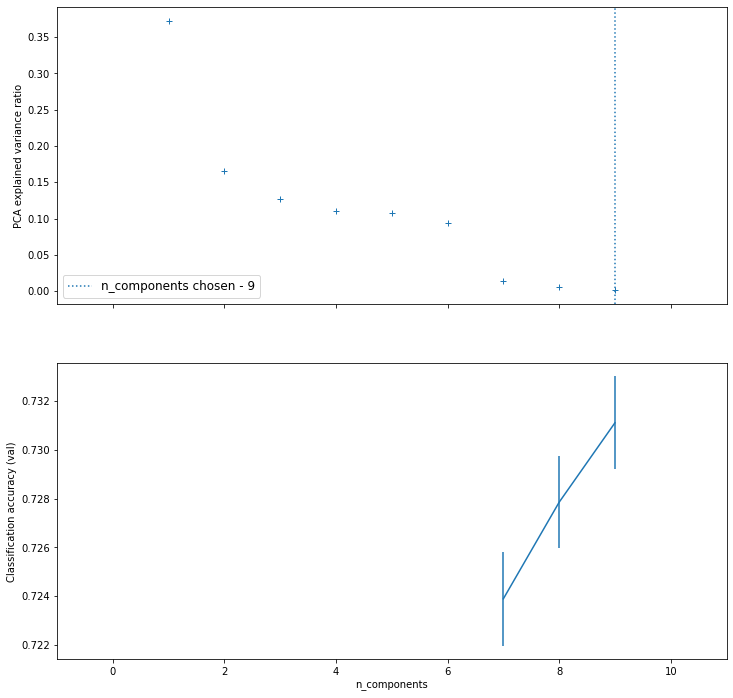

In [273]:
sgd_gsrch = gsrch_clf(SGDClassifier(), param_grid_sgd, train_x[:20000], train_y[:20000])

In [275]:
mnb_gsrch = gsrch_clf(MultinomialNB(), param_grid_multinb, train_x[:20000], train_y[:20000], False)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameter (CV score=0.531):
{'clf__alpha': 350.0, 'clf__fit_prior': True, 'nmf__init': None, 'nmf__n_components': 4, 'nmf__solver': 'cd'}

[[23553  3998]
 [21911  5654]]

Accuracy: 0.529918716888018


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.3s finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.8s finished


Best parameter (CV score=0.668):
{'clf__alpha': 650.0, 'pca__n_components': 6}

[[17534 10017]
 [ 8124 19441]]

Accuracy: 0.6708578271282386


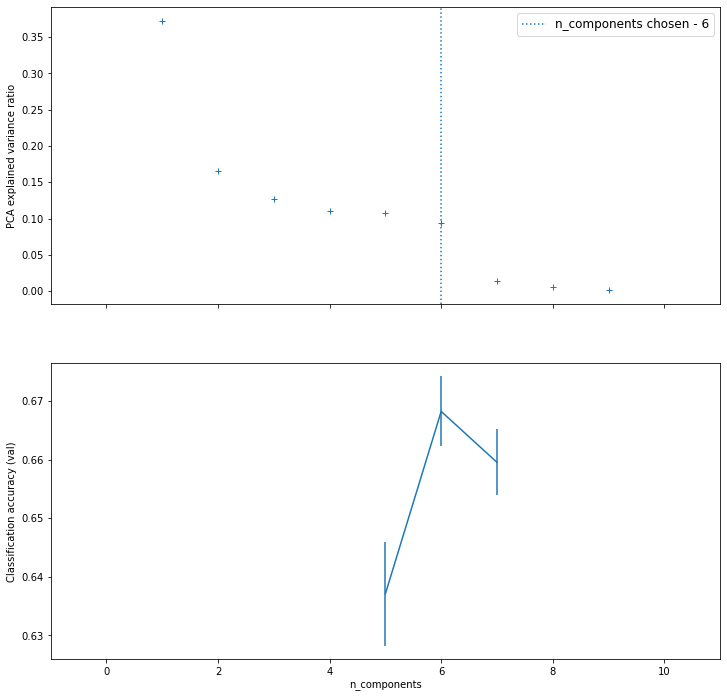

In [272]:
bernb_gsrch = gsrch_clf(BernoulliNB(), param_grid_bernoulli, train_x[:20000], train_y[:20000])

In [276]:
compnb_gsrch = gsrch_clf(ComplementNB(), param_grid_compnb, train_x[:20000], train_y[:20000], False)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameter (CV score=0.530):
{'clf__alpha': 850.0, 'clf__norm': True, 'nmf__init': None, 'nmf__n_components': 3, 'nmf__solver': 'cd'}

[[23553  3998]
 [21911  5654]]

Accuracy: 0.529918716888018


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.9s finished


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier

RSEED = 50

# Load in data
df = pd.read_csv('https://s3.amazonaws.com/projects-rf/clean_data.csv')

# Full dataset: https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [2]:
test.head(50)

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
27641,47.0,3.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.000000,1.0,1.0,2.000000,...,1.0,1.0,2.000000,2.000000,3.000000,1.0,1.0,2.319407,2.411545,2.000000
23552,10.0,2.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.000000,1.0,1.0,1.000000,...,1.0,1.0,3.000000,3.000000,4.000000,1.0,1.0,2.319407,2.411545,2.000000
20328,33.0,2.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.000000,1.0,1.0,1.000000,...,2.0,2.0,3.000000,3.000000,4.000000,1.0,1.0,2.319407,2.411545,1.000000
76174,34.0,11.0,1100.0,2.015011e+09,2.015011e+09,1.0,1.000116,1.0,1.0,1.539894,...,4.0,2.0,3.000000,3.000000,4.000000,1.0,1.0,2.319407,2.411545,2.000000
74306,30.0,12.0,1100.0,2.015006e+09,2.015006e+09,1.0,1.000116,1.0,1.0,1.539894,...,4.0,2.0,3.000000,3.000000,4.000000,1.0,1.0,2.319407,2.411545,9.000000
14848,6.0,10.0,1100.0,2.015011e+09,2.015011e+09,1.0,1.000116,1.0,1.0,1.539894,...,2.0,2.0,3.000000,3.000000,4.000000,1.0,1.0,1.000000,1.000000,2.000000
37022,27.0,5.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.000000,1.0,1.0,1.000000,...,4.0,2.0,3.000000,3.000000,4.000000,1.0,1.0,2.319407,2.411545,2.000000
77381,55.0,6.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.000116,1.0,1.0,1.539894,...,3.0,2.0,3.000000,3.000000,4.000000,1.0,1.0,2.319407,2.411545,1.000000
1613,50.0,6.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.000000,1.0,1.0,1.000000,...,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.0,1.000000,2.000000,2.000000
59602,27.0,6.0,1100.0,2.015004e+09,2.015004e+09,1.0,1.000000,1.0,1.0,1.000000,...,3.0,2.0,1.000000,1.000000,2.000000,1.0,1.0,2.319407,2.411545,1.000000
